In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.kernel_approximation import RBFSampler

In [198]:
def generar_x(n, num_variables):
    part1 = np.random.uniform(0, 1, (n, num_variables))
    return part1

# para elegir la transfomracioń (o las transformaciones para cada variable) usar Random Fourier Features

n = 10 # Número de datos (filas de X)
num_variables = 2 # Número de variables
d = 2 # Dimension de la transformación

x = generar_x(n, num_variables)
epsilon = np.random.normal(0,1,size=n) # Ruido

y = 3*x[:,0]**2 - 2*x[:,0]*x[:,1] + 2*x[:,1] + epsilon

# Transformación Polinomial
phi1 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(np.column_stack((x[:,0], x[:,1]))) # d = 5

# Transformaciones mediante Random Fourier Features
phi2 = RBFSampler(n_components=d, random_state=0).fit_transform(np.column_stack((x[:,0], x[:,1])))

w_1 = np.linalg.inv(np.dot(x.T, x)).dot(x.T).dot(y)
w_2 = np.linalg.inv(np.dot(phi2.T, phi2)).dot(phi2.T).dot(y)

# f(x) = phi(x)*w^T, f(x) es el "modelo" que estamos aprendidendo, en este caso le estamos exigiendo que las transformaciones sean ideales, y que en el nuevo espacio aumentado, la relación lineal sea perfecta y los errores sean 0
# básicamente estamos imponiendo que el modelo aprendido se ajuste perfectamente a los datos que tenemos
y_hat_1 = np.dot(x, w_1)
y_hat_2 = np.dot(phi2, w_2)

# comparar el error cuadrático medio
print("Error cuadrático medio con polinomio: ", np.mean((y - y_hat_1)**2))
print("Error cuadrático medio con Random Fourier Features: ", np.mean((y - y_hat_2)**2))
# El d mínimo es 10, ya que n será igual a d y tendremos un sistema de ecuaciones lineales con solución única (compatible determinado) 
# Básicamente, quiero transformar mis datos a una dimensión en la que mi problema tiene solución n >= d

# Para valores grandes de n, llegar a d transformaciones que sean linealmente independientes puede ser tarea difícil, por ello, la mejor forma 
# de resolver esto es introduciendo aleatoriedad en las transformaciones que hacemos. Ver apuntes 


Error cuadrático medio con polinomio:  0.887519471869102
Error cuadrático medio con Random Fourier Features:  1.1190331901367752


In [77]:
# programar el algoritmo de Random Fourier Features manualmente
def random_fourier_features(x, W, b, p):
    return np.sqrt(2/p)*np.cos(np.dot(x, W) + b)

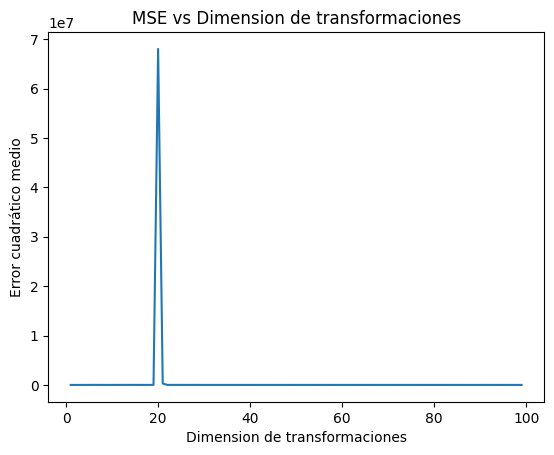

In [190]:
n_train = 20
num_variables = 2
n_test = 1000
p_values = np.arange(1, 100, 1)

x_train = generar_x(n_train, num_variables)
x_test = generar_x(n_test, num_variables)
epsilon = np.random.normal(0,1,size=n_train)
y_train = 3*x_train[:,0]**2 - 2*x_train[:,0]*x_train[:,1] + 2*x_train[:,1] + epsilon
y_test = 3*x_test[:,0]**2 - 2*x_test[:,0]*x_test[:,1] + 2*x_test[:,1]


mses = []
for p in p_values:
    # phi = RBFSampler(n_components=p, random_state=0).fit(x_train) # entreno el modelo con los datos de train
    # phi_de_test = phi.transform(x_test) # aplico el modelo a los datos de test
    # obtengo los valore W y b para el calculo de las random fourier features, lo saco fuera para que sean los mismos para todas las veces en las que aplicamos las tranformaciones phi
    W = np.random.normal(0, 1, (num_variables, p))
    b = np.random.uniform(0, 2*np.pi, p)
    
    phi_de_x_train = random_fourier_features(x_train, W, b ,p) # con la transformación de x_train entreno mis w
    phi_de_x_test = random_fourier_features(x_test, W, b, p) # con la (transformación de x_test)*w obtengo mis predicciones
    
    if(p>n_train):
        w = np.dot(np.dot(phi_de_x_train.T,np.linalg.inv(np.dot(phi_de_x_train,phi_de_x_train.T))),y_train)
    else:
        w = np.dot(np.dot(np.linalg.inv(np.dot(phi_de_x_train.T,phi_de_x_train)),phi_de_x_train.T),y_train)
    
    y_pred = np.dot(phi_de_x_test, w)
    mses.append(np.mean((y_test - y_pred)**2))

plt.plot(p_values, mses)
plt.title("MSE vs Dimension de transformaciones")
plt.xlabel("Dimension de transformaciones")
plt.ylabel("Error cuadrático medio")
plt.show()
